# CS546 Network In Compute Biology Final Project

#Topic: Network Analysis of Drug-Target Gene Interaction

#### Names: JuHyun Kim, Ryan Roberts, Zexian Li


# 1. Overview

The purpose of this project is to guide the analysis of the drug-gene interaction network, providing valuable insights into drug action, potential side effects, and opportunities for drug repurposing. Along side the general analysis questions stated below, we will also ask the following specific question: **Are any of the top five most popular drugs that target the 5-hydroxytryptamine receptor genes (2A, 2B, 2C) in the human brain the most popular drug in the entire network?**

General Analysis:
- What is the structural characterization of the drug-target interaction network?
- How are drugs and target genes interconnected within the network?
- Which drugs are central to the network and what does this suggest about their role in therapeutic treatments?
- Is there a correlation between node degree and betweenness centrality in the drug-gene interaction network?
- What are the implications of network metrics like path length and diameter for drug discovery and development?


In [67]:
# install and import igraph:
! pip install python-igraph
import igraph
import pandas as pd
import collections, scipy.stats
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [68]:
# data import by link
!curl https://snap.stanford.edu/biodata/datasets/10016/files/ChG-InterDecagon_targets.csv.gz --output "ChG-InterDecagon_targets.csv.gz"
!gunzip -f ChG-InterDecagon_targets.csv.gz > ChG-InterDecagon_targets.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  431k  100  431k    0     0   193k      0  0:00:02  0:00:02 --:--:--  193k


# 2. Dataprocessing

In [69]:
df = pd.read_csv("ChG-InterDecagon_targets.csv",sep=",",names=["Drug","tGene"], header=0, dtype=str)
df.head(10)

,Drug,tGene
0,CID000060752,3757
1,CID006918155,2908
2,CID103052762,3359
3,CID023668479,1230
4,CID000028864,1269
5,CID000028864,124274
6,CID000028864,2849
7,CID000028864,2847
8,CID000028864,2844
9,CID000028864,2845


In [70]:
# Check for missing values
print(df.isnull().sum())

# Remove duplicates if any
df.drop_duplicates(inplace=True)

# Final structure
df.head(10)

Drug     0
tGene    0
dtype: int64


,Drug,tGene
0,CID000060752,3757
1,CID006918155,2908
2,CID103052762,3359
3,CID023668479,1230
4,CID000028864,1269
5,CID000028864,124274
6,CID000028864,2849
7,CID000028864,2847
8,CID000028864,2844
9,CID000028864,2845


In [71]:
# Create the igraph.Graph representation of the network:
g = igraph.Graph.TupleList(df.values.tolist(), directed=False)
g.vs['type'] = ['drug' if node["name"].startswith('CID') else 'gene' for node in g.vs]
g.summary()

'IGRAPH UN-T 9569 131034 -- \n+ attr: name (v), type (v)'

# 3.Network Analysis


In [72]:
# Calculate the number of vertices and edges
num_vertices = g.vcount()
num_edges = g.ecount()
print(f"Number of vertices (nodes): {num_vertices}")
print(f"Number of edges: {num_edges}")

# Calculate the number of connected ocmponets
components = g.components()
num_components = len(components)
print(f"Number of connected components: {num_components}")


Number of vertices (nodes): 9569
Number of edges: 131034
Number of connected components: 8


In [73]:
# calculate the distribution of node degrees
degree_distribution = np.array(g.degree())
degree_distribution

array([  1, 154,   1, ..., 158,  94,   2])

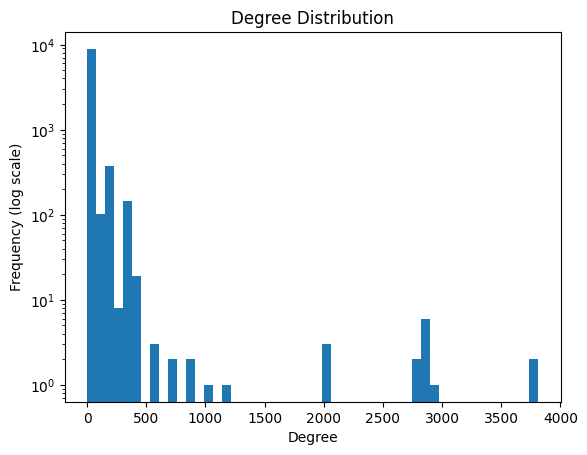

In [74]:
#plot the distribution of node degrees
plt.hist(degree_distribution, bins=50, log=True)  # log scale for better visibility
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency (log scale)")
plt.show()

In [75]:
# Calculate average path length and network diameter
try:
    avg_path_length = g.average_path_length()
    print(f"Average path length: {avg_path_length}")
except:
    print("Average path length: Graph is not connected, calculation is not possible.")

print(f"Network diameter: {g.diameter()}")

Average path length: 2.9731504983637937
Network diameter: 9


In [76]:
# The ID's of our target genes: 5-hydroxytryptamine receptor 2A, 2B, and 2C
target_gene_ids = ['3356', '3357', '3358']
target_vertices = [v.index for v in g.vs if v['name'] in target_gene_ids]

# Calculate betweenness centrality for all nodes
betweenness = g.betweenness()
g.vs['betweenness'] = betweenness

# Calculate closeness centrality for all nodes
closeness = g.closeness()
g.vs['closeness'] = closeness

# Identify drugs targeting the disease of interest based on target genes
drugs_targeting_disease = [v.index for v in g.vs if v['type'] == 'drug' and any(g.are_connected(v.index, t) for t in target_vertices)]

# Drugs with high betweenness might be controlling the flow in critical paths
top_drugs_by_betweenness = sorted([(g.vs[d]['name'], g.vs[d]['betweenness']) for d in drugs_targeting_disease], key=lambda x: x[1], reverse=True)[:5]
print("Top 5 drugs by betweenness centrality targeting the disease:", top_drugs_by_betweenness)


Top 5 drugs by betweenness centrality targeting the disease: [('CID100000175', 5147596.904747258), ('CID100000312', 4410139.899743438), ('CID000023994', 4043917.315009064), ('CID100023994', 4041057.8279495933), ('CID100000206', 1508520.2938852662)]


In [77]:
# Calculate centrality measures
betweenness = g.betweenness()
closeness = g.closeness()

# Identify nodes with highest centrality measures
max_betweenness = max(betweenness)
max_closeness = max(closeness)

central_node_betweenness = betweenness.index(max_betweenness)
central_node_closeness = closeness.index(max_closeness)

print(f"Node with highest betweenness centrality: {g.vs[central_node_betweenness]['name']}")
print(f"Node with highest closeness centrality: {g.vs[central_node_closeness]['name']}")


Node with highest betweenness centrality: CID000000753
Node with highest closeness centrality: 624


# 4. Results



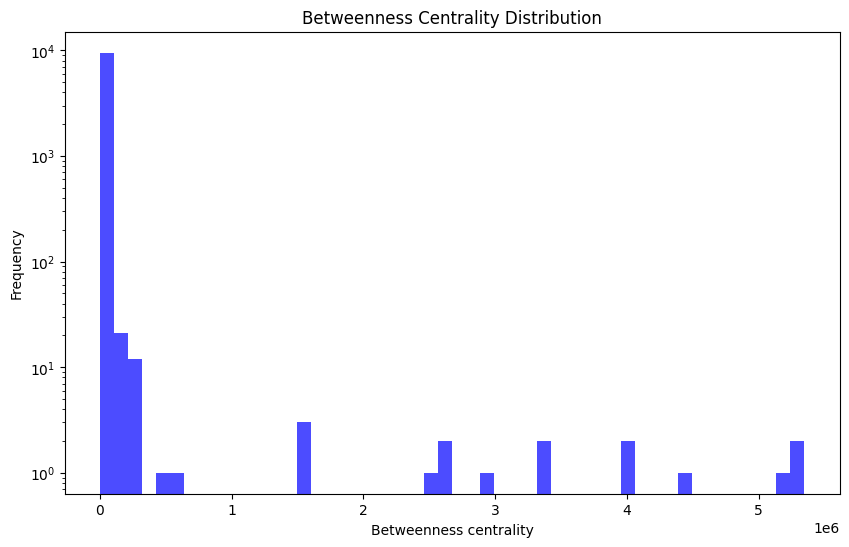

In [78]:
import matplotlib.pyplot as plt

# Extract betweenness centrality scores
betweenness_values = g.vs['betweenness']

plt.figure(figsize=(10, 6))
plt.hist(betweenness_values, bins=50, color='blue', alpha=0.7)
plt.title('Betweenness Centrality Distribution')
plt.xlabel('Betweenness centrality')
plt.ylabel('Frequency')
plt.yscale('log', nonpositive='clip')  # Log scale for better visibility of distribution
plt.show()


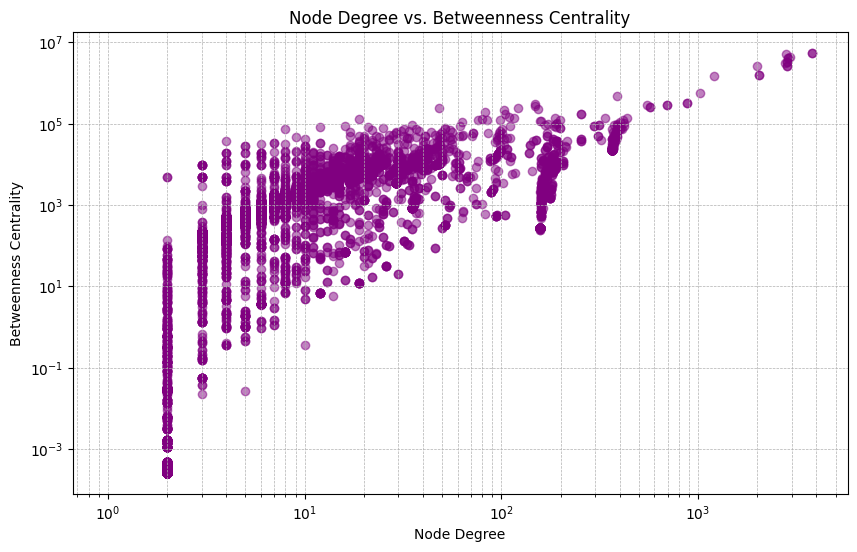

In [79]:
# Calculate node degrees for the x-axis
node_degrees = g.degree()

# Use betweenness centrality for the y-axis
node_betweenness = g.betweenness()

plt.figure(figsize=(10, 6))
plt.scatter(node_degrees, node_betweenness, color='purple', alpha=0.5)
plt.title('Node Degree vs. Betweenness Centrality')
plt.xlabel('Node Degree')
plt.ylabel('Betweenness Centrality')
plt.yscale('log')  # Use log scale for betweenness centrality
plt.xscale('log')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()


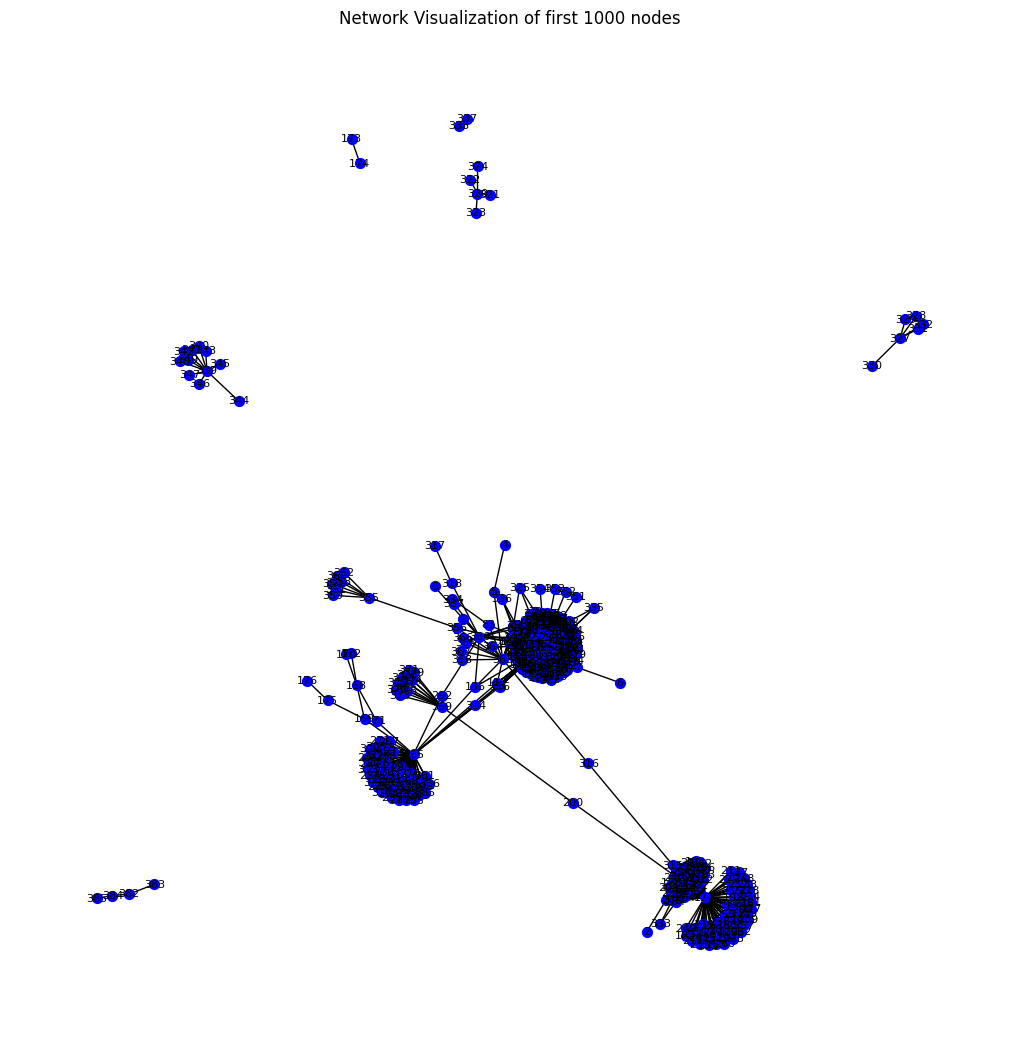

In [80]:
import networkx as nx
import matplotlib.pyplot as plt

G_nx = nx.Graph()

# Add edges from the igraph object
G_nx.add_edges_from([(edge.source, edge.target) for edge in g.es[:1000]])

plt.figure(figsize=(10, 10))
nx.draw(G_nx, node_color='blue', with_labels=True, node_size=50, font_size=8)
plt.title('Network Visualization of first 1000 nodes')
plt.show()


# 5. General Analysis Discussion

1. **Structural Characterization of the Drug-Target Interaction Network:**
   - The network is undirected, consisting of nodes (drugs and target genes) and edges representing the interactions between them.
   - It has 9,569 nodes and 131,034 edges, indicating a dense network with many interactions per node.
   - The network diameter is 9, meaning the longest shortest path between any two nodes is nine edges.
   - The degree distribution graph shows a heavy-tailed distribution, suggesting a scale-free network where a few nodes (hubs) have a very high number of connections, while most have relatively few.
   - The network contains 8 connected components, which means there are 8 separate sub-networks within the larger network that do not connect to each other. This could suggest the presence of distinct groups or clusters in the drug-gene interaction space.

2. **Interconnections Between Drugs and Target Genes Within the Network:**
   - The histogram of degree distribution suggests that most nodes have a low number of connections, but there are a few highly connected nodes. This implies that most drugs target a small number of genes, while a few drugs might have a broad range of targets or a few genes are targeted by many drugs.
   - The betweenness centrality distribution graph further highlights nodes that act as bridges or bottlenecks within the network.

3. **Central Drugs in the Network:**
   - The top five drugs identified by betweenness centrality are potential key players in the network. High betweenness centrality implies that these drugs are involved in many shortest paths between other nodes and could therefore play a significant role in how the network functions.
   - These central drugs could be critical for therapeutic treatments as they might influence multiple pathways or gene interactions. They may be considered for multi-target therapies or could be vital for understanding side effects and drug interactions.

4. **Correlation Between Node Degree and Betweenness Centrality:**
   - The scatter plot comparing node degree with betweenness centrality shows that there is not a strict direct correlation between the two metrics. While nodes with a higher degree tend to have higher betweenness centrality, there are nodes with low degree but high betweenness and vice versa. This suggests that some nodes may hold strategic positions within the network despite having fewer connections.

5. **Implications of Network Metrics for Drug Discovery and Development:**
   - The average path length of approximately 2.973 suggests a small-world phenomenon, where any node is reachable from any other through only a few steps. This could be advantageous in drug discovery, where the effects of a drug on a target can quickly propagate through the network, potentially affecting multiple pathways.
   - A smaller diameter (9 in this case) indicates that the network is relatively compact, which could be beneficial for understanding the overall connectivity of the network and how drugs can impact various biological pathways.
   - These metrics suggest that therapeutic interventions might be developed by targeting the hubs or central nodes within the network, which could lead to more effective treatments. However, targeting hubs can also increase the risk of side effects due to their multiple connections.
   - Understanding the structure of the network helps in identifying potential off-target effects of drugs, predicting drug interactions, and exploring new uses for existing drugs (drug repurposing).


#6. Conclusion

In conclusion, the answer to our research question is that the top five most popular drugs (by betweenness centrality) targeting the 5-hydroxytryptamine receptor genes are Methanamine, Pyridine-2-carboxamide, Zinc, Propanamide, and Benzamide. None of these were the most popular drug in the network (again, by betweenness centrality) which happened to be Glycose.

Overall, the dataset we analyze has revealed a complex but structured web of relationships characterized by scale-free properties and small-world phenomena. Hubs within the network, marked by drugs with high betweenness centrality, could play a crucial role in multiple pathways, highlighting their potential in multi-target therapeutic strategies and the need for careful consideration of side effects. Despite the insights gained, the network's structural metrics like path length and diameter indicate that there's more to unravel about the connectivity and flow of influence within this network. For future work, it would be valuable to explore the dynamic aspects of the network, such as how the addition or removal of edges (such as interactions) affects overall network properties, and to employ machine learning techniques to predict potential new drug-target interactions. This could further enhance our understanding of the network's robustness and our ability to manipulate it for therapeutic benefit, paving the way for precision medicine and more targeted drug development.

# Reference

- Data Set: https://snap.stanford.edu/biodata/datasets/10016/10016-ChG-InterDecagon.html

- for tGenes: https://www.ncbi.nlm.nih.gov/gene/?term=3757%5Buid%5D

- for drugs (chemicals): https://pubchem.ncbi.nlm.nih.gov/

- Marinka Zitnik, Monica Agrawal, Jure Leskovec, Modeling polypharmacy side effects with graph convolutional networks, Bioinformatics, Volume 34, Issue 13, July 2018, Pages i457–i466, https://doi.org/10.1093/bioinformatics/bty294

- class materials (slide and Notebook)
